In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [5]:
df_train = pd.read_csv("./data/act_train.csv")
df_test = pd.read_csv("./data/act_test.csv")
df_people = pd.read_csv("./data/people.csv")


In [6]:
df_test.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [7]:
# Add missing outcome to test
df_test["outcome"] = np.nan

In [8]:
df_train.dtypes

people_id            object
activity_id          object
date                 object
activity_category    object
char_1               object
char_2               object
char_3               object
char_4               object
char_5               object
char_6               object
char_7               object
char_8               object
char_9               object
char_10              object
outcome               int64
dtype: object

In [9]:
df_test.dtypes

people_id             object
activity_id           object
date                  object
activity_category     object
char_1                object
char_2                object
char_3                object
char_4                object
char_5                object
char_6                object
char_7                object
char_8                object
char_9                object
char_10               object
outcome              float64
dtype: object

In [10]:
df_people.dtypes

people_id    object
char_1       object
group_1      object
char_2       object
date         object
char_3       object
char_4       object
char_5       object
char_6       object
char_7       object
char_8       object
char_9       object
char_10        bool
char_11        bool
char_12        bool
char_13        bool
char_14        bool
char_15        bool
char_16        bool
char_17        bool
char_18        bool
char_19        bool
char_20        bool
char_21        bool
char_22        bool
char_23        bool
char_24        bool
char_25        bool
char_26        bool
char_27        bool
char_28        bool
char_29        bool
char_30        bool
char_31        bool
char_32        bool
char_33        bool
char_34        bool
char_35        bool
char_36        bool
char_37        bool
char_38       int64
dtype: object

In [11]:
# Convert types
df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])
df_people["date"] = pd.to_datetime(df_people["date"])

df_train["people_id"] = df_train["people_id"].astype(str)
df_test["people_id"] = df_test["people_id"].astype(str)
df_people["people_id"] = df_people["people_id"].astype(str)

df_train["activity_id"] = df_train["activity_id"].astype(str)
df_test["activity_id"] = df_test["activity_id"].astype(str)


In [12]:
df_train.isnull().sum()

people_id                  0
activity_id                0
date                       0
activity_category          0
char_1               2039676
char_2               2039676
char_3               2039676
char_4               2039676
char_5               2039676
char_6               2039676
char_7               2039676
char_8               2039676
char_9               2039676
char_10               157615
outcome                    0
dtype: int64

In [13]:
df_test.isnull().sum()

people_id                 0
activity_id               0
date                      0
activity_category         0
char_1               458595
char_2               458595
char_3               458595
char_4               458595
char_5               458595
char_6               458595
char_7               458595
char_8               458595
char_9               458595
char_10               40092
outcome              498687
dtype: int64

In [14]:
# Fill missing char columns
char_cols = [f"char_{i}" for i in range(1, 11)]
for col in char_cols:
    df_train[col] = df_train[col].fillna("type 0")
    df_test[col] = df_test[col].fillna("type 0")

The people.csv file contains static demographic and behavioral attributes for each unique individual who appears in both the act_train.csv and act_test.csv datasets.

1. people_id -> Unique identifier for each person
2. date -> Date the person record was last updated or created
3. group_1 -> Categorical grouping of people (e.g., customer segment, profile group)
4. char_1 to char_10 -> Mostly binary features (boolean) describing user characteristics
5. char_11 to char_38 -> Categorical features with varying cardinality (many are type-based values like type 5, type 42)

### EDA

### Data preprocessing

In [15]:
common_columns = df_train.columns.intersection(df_people.columns)

print(common_columns)


Index(['people_id', 'date', 'char_1', 'char_2', 'char_3', 'char_4', 'char_5',
       'char_6', 'char_7', 'char_8', 'char_9', 'char_10'],
      dtype='object')


- act_train.csv / act_test.csv: These files contain activity records for individuals, including fields like activity_id, date, activity_category, and char_1 to char_10.

- people.csv: This file provides information about each person, such as group_1, char_1 to char_38, and a date field indicating when the person's record was created or last updated.

To enrich the activity data with person-specific information, we will perform a left join on the people_id column:

1. people_id: This is the unique identifier linking activity records to the corresponding person details.

2. Common Columns (char_1 to char_10, date): While these columns exist in both datasets, they represent different information:
- In act_train / act_test these fields pertain to specific activities.
- In people.csv these fields describe attributes of the individuals.

In [16]:
df_merged = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_merged = df_merged.merge(df_people, on="people_id", how="left")

In [17]:
df_merged.head()

,people_id,activity_id,date_x,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,char_10_x,outcome,char_1_y,group_1,char_2_y,date_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y,char_10_y,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,act2_1734928,2023-08-26,type 4,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 76,0.0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100,act2_2434093,2022-09-27,type 2,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 1,0.0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
2,ppl_100,act2_3404049,2022-09-27,type 2,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 1,0.0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
3,ppl_100,act2_3651215,2023-08-04,type 2,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 1,0.0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
4,ppl_100,act2_4109017,2023-08-26,type 2,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 0,type 1,0.0,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36


After merging it is crucial to rename overlapping columns to prevent confusion and maintain clarity

In [18]:
df_merged = df_merged.rename(columns={
    "date_x": "activity_date",
    "date_y": "person_date",
    **{f"char_{i}_x": f"activity_char_{i}" for i in range(1, 11)},
    **{f"char_{i}_y": f"person_char_{i}" for i in range(1, 10)}
})


After merging act with people on people_id, several columns appear with suffixes like _x and _y. These suffixes were added by pandas to help distinguish overlapping columns between the two datasets. I renamed them to avoid confusion

In [19]:
len(df_merged[df_merged['group_1'] == 'group 17304'])/len(df_merged)

0.3578400862321577

In [20]:
df_merged[df_merged['group_1'] == 'group 17304']['outcome'].unique()

array([ 0., nan])

In [21]:
# Store rows with 'group 17304'
excluded_rows = df_merged[df_merged['group_1'] == 'group 17304'].copy()

# Proceed to filter out 'group 17304' from the main dataset
df_merged = df_merged[df_merged['group_1'] != 'group 17304']


In [22]:
df_merged['outcome'].value_counts()

outcome
1.0    975497
0.0    422669
Name: count, dtype: int64

Imbalanced

### Feature Engineering

In [23]:
# Extract components from 'person_date'
df_merged['person_year'] = df_merged['person_date'].dt.year
df_merged['person_month'] = df_merged['person_date'].dt.month
df_merged['person_day'] = df_merged['person_date'].dt.day
df_merged['person_week'] = df_merged['person_date'].dt.isocalendar().week
df_merged['person_day_of_week'] = df_merged['person_date'].dt.dayofweek  # Monday=0, Sunday=6

# Extract components from 'activity_date'
df_merged['activity_year'] = df_merged['activity_date'].dt.year
df_merged['activity_month'] = df_merged['activity_date'].dt.month
df_merged['activity_day'] = df_merged['activity_date'].dt.day
df_merged['activity_week'] = df_merged['activity_date'].dt.isocalendar().week
df_merged['activity_day_of_week'] = df_merged['activity_date'].dt.dayofweek  # Monday=0, Sunday=6


In [24]:
# -----------------------------
# Group-Level Aggregations
# -----------------------------

# Calculate the number of unique people per group
unique_people_per_group = df_merged[['group_1', 'people_id']].drop_duplicates()
group_people_count = unique_people_per_group.groupby('group_1')['people_id'].nunique().reset_index(name='group_people_count')
df_merged = df_merged.merge(group_people_count, on='group_1', how='left')


In [25]:
# Calculate the earliest 'person_date' within each group
min_person_date_per_group = df_merged.groupby('group_1')['person_date'].transform('min')
df_merged['days_since_earliest_person_date'] = (df_merged['person_date'] - min_person_date_per_group).dt.days

# Calculate the latest 'person_date' within each group
max_person_date_per_group = df_merged.groupby('group_1')['person_date'].transform('max')
df_merged['days_until_latest_person_date'] = (max_person_date_per_group - df_merged['person_date']).dt.days


In [26]:
# Calculate the total number of activities per group
group_activity_count = df_merged.groupby('group_1')['activity_id'].count().reset_index(name='group_activity_count')
df_merged = df_merged.merge(group_activity_count, on='group_1', how='left')

# Calculate activities per capita within each group
df_merged['activities_per_person_in_group'] = df_merged['group_activity_count'] / df_merged['group_people_count']


In [27]:
# -----------------------------
# Person-Level Aggregations
# -----------------------------

# Calculate the number of activities per person
activity_count_per_person = df_merged.groupby('people_id')['activity_id'].count().reset_index(name='activity_count_per_person')
df_merged = df_merged.merge(activity_count_per_person, on='people_id', how='left')


In [28]:
# Calculate the absolute difference in days between 'activity_date' and 'person_date'
df_merged['activity_person_date_diff'] = (df_merged['activity_date'] - df_merged['person_date']).abs().dt.days


In [29]:
# Flag if the activity occurred on a weekend (Saturday=5, Sunday=6)
df_merged['is_weekend_activity'] = df_merged['activity_date'].dt.dayofweek >= 5

# Extract the quarter from 'activity_date'
df_merged['activity_quarter'] = df_merged['activity_date'].dt.quarter

# Calculate the most recent activity date per person
df_merged['most_recent_activity_date'] = df_merged.groupby('people_id')['activity_date'].transform('max')
df_merged['days_since_most_recent_activity'] = (df_merged['activity_date'] - df_merged['most_recent_activity_date']).dt.days


In [30]:
# -----------------------------
# Additional Features
# -----------------------------

# Calculate the delay on weekends by multiplying the date difference with the weekend flag
df_merged['delay_on_weekend'] = df_merged['activity_person_date_diff'] * df_merged['is_weekend_activity']


In [31]:
# Calculate the average delay per person
average_delay_per_person = df_merged.groupby('people_id')['activity_person_date_diff'].mean().reset_index(name='average_delay_per_person')
df_merged = df_merged.merge(average_delay_per_person, on='people_id', how='left')


In [32]:
# Calculate the ratio of weekend activities per person
weekend_activity_count = df_merged.groupby('people_id')['is_weekend_activity'].sum().reset_index(name='weekend_activity_count')
total_activity_count = df_merged.groupby('people_id')['activity_id'].count().reset_index(name='total_activity_count')
weekend_activity_ratio = pd.merge(weekend_activity_count, total_activity_count, on='people_id')
weekend_activity_ratio['weekend_activity_ratio'] = weekend_activity_ratio['weekend_activity_count'] / weekend_activity_ratio['total_activity_count']
df_merged = df_merged.merge(weekend_activity_ratio[['people_id', 'weekend_activity_ratio']], on='people_id', how='left')


In [33]:
# Apply cyclical encoding to 'activity_day_of_week' to capture its cyclical nature
df_merged['activity_day_of_week_sin'] = np.sin(2 * np.pi * df_merged['activity_day_of_week'] / 7)
df_merged['activity_day_of_week_cos'] = np.cos(2 * np.pi * df_merged['activity_day_of_week'] / 7)


In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
bool_cols = df_merged.select_dtypes(include='bool').columns
df_merged[bool_cols] = df_merged[bool_cols].astype(int)

In [36]:
categorical_cols = df_merged.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['people_id', 'activity_id']]

In [37]:
# Classify by cardinality
low_cardinality_cols = []
high_cardinality_cols = []
for col in categorical_cols:
    if df_merged[col].nunique() <= 20:
        low_cardinality_cols.append(col)
    else:
        high_cardinality_cols.append(col)

# One-hot encode low cardinality
df_merged = pd.get_dummies(df_merged, columns=low_cardinality_cols, drop_first=True)

# Label encode high cardinality
label_encoders = {}
for col in high_cardinality_cols:
    le = LabelEncoder()
    df_merged[col] = le.fit_transform(df_merged[col].astype(str))
    label_encoders[col] = le

In [38]:
activity_ids = df_merged.loc[df_merged['outcome'].isna(), 'activity_id'].values

In [39]:
df_merged.dtypes

people_id                                  object
activity_id                                object
activity_date                      datetime64[ns]
activity_char_1                             int64
activity_char_2                             int64
activity_char_10                            int64
outcome                                   float64
group_1                                     int64
person_date                        datetime64[ns]
person_char_3                               int64
person_char_4                               int64
person_char_7                               int64
char_10_y                                   int64
char_11                                     int64
char_12                                     int64
char_13                                     int64
char_14                                     int64
char_15                                     int64
char_16                                     int64
char_17                                     int64


In [40]:
drop_cols = ['activity_date', 'person_date', 'people_id', 'activity_id', 'most_recent_activity_date']
df_merged = df_merged.drop(columns=drop_cols)


In [41]:
training_data = df_merged[df_merged['outcome'].notna()].copy()
testing_data = df_merged[df_merged['outcome'].isna()].copy()


## Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [43]:
X = training_data.drop(columns=['outcome'])
y = training_data['outcome'].astype(int)


X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)


In [45]:
from imblearn.over_sampling import SMOTE

In [46]:
# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_tr_resampled, y_tr_resampled = smote.fit_resample(X_tr_scaled, y_tr)

In [47]:
from collections import Counter

In [48]:
# Display class distribution before and after SMOTE
print("Before SMOTE:", Counter(y_tr))
print("After SMOTE:", Counter(y_tr_resampled))

Before SMOTE: Counter({1: 780397, 0: 338135})
After SMOTE: Counter({1: 780397, 0: 780397})


In [49]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_tr_resampled, y_tr_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [50]:
y_tr_pred = log_reg.predict(X_tr_scaled)
y_val_pred = log_reg.predict(X_val_scaled)
y_val_probs = log_reg.predict_proba(X_val_scaled)[:, 1]


train_acc = accuracy_score(y_tr, y_tr_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Train Accuracy: 0.7502
Validation Accuracy: 0.7502


In [51]:
# Evaluation
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("AUC-ROC Score:", roc_auc_score(y_val, y_val_probs))


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.74      0.64     84534
           1       0.87      0.75      0.81    195100

    accuracy                           0.75    279634
   macro avg       0.72      0.75      0.73    279634
weighted avg       0.78      0.75      0.76    279634

Confusion Matrix:
 [[ 62555  21979]
 [ 47863 147237]]
Validation Accuracy: 0.7502378108527575
AUC-ROC Score: 0.8336478078989129


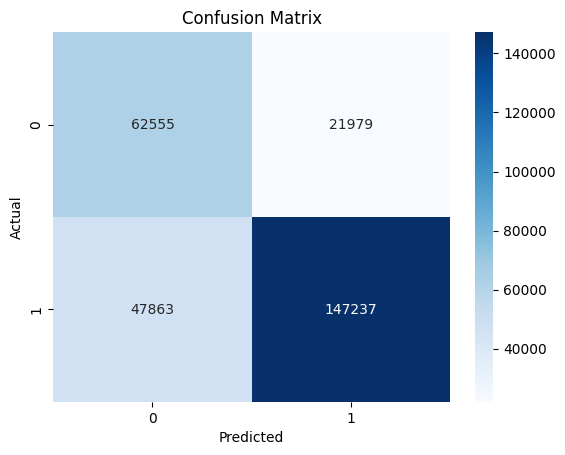

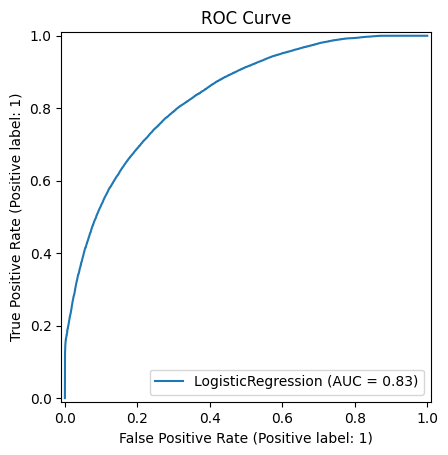

In [52]:
# Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
RocCurveDisplay.from_estimator(log_reg, X_val_scaled, y_val)
plt.title("ROC Curve")
plt.show()


In [53]:
X_test_scaled = scaler.transform(testing_data.drop(columns=['outcome']))

In [54]:
y_test_probs = log_reg.predict_proba(X_test_scaled)[:, 1]

submission = pd.DataFrame({
    'activity_id': activity_ids,
    'outcome': y_test_probs
})

In [55]:
# Identify test data within the excluded rows
excluded_test_rows = excluded_rows[excluded_rows['outcome'].isna()].copy()
# Assign a default outcome value
excluded_test_rows['outcome'] = 0

In [56]:
submission = pd.concat([submission, excluded_test_rows[['activity_id', 'outcome']]], ignore_index=True)

# Optional: Sort by 'activity_id' if required
submission = submission.sort_values('activity_id').reset_index(drop=True)


In [58]:
len(submission)

498687

In [59]:
submission.to_csv('submission_log_reg.csv', index=False)


## Tree and Ensemble Models

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [61]:
from sklearn.model_selection import cross_val_score

In [62]:
def evaluate_model(model, model_name, X_tr, X_val, y_tr, y_val, cv_folds=5):
    print(f"\n{'='*10} {model_name} {'='*10}")
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=cv_folds, scoring='roc_auc')
    print(f"Cross-Validation AUC-ROC Scores: {cv_scores}")
    print(f"Mean CV AUC-ROC Score: {cv_scores.mean():.4f}")
    
    # Train the model
    model.fit(X_tr, y_tr)
    
    # Predict
    y_tr_pred = model.predict(X_tr)
    y_val_pred = model.predict(X_val)
    y_val_probs = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else y_val_pred

    # Accuracy
    train_acc = accuracy_score(y_tr, y_tr_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # Report
    print("Classification Report:\n", classification_report(y_val, y_val_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    print("AUC-ROC Score:", roc_auc_score(y_val, y_val_probs))

    # Confusion Matrix plot
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f"ROC Curve - {model_name}")
    plt.show()



========== XGBoost ==========
Cross-Validation AUC-ROC Scores: [0.96545973 0.96639768 0.96456603 0.96843164 0.96570776]
Mean CV AUC-ROC Score: 0.9661
Train Accuracy: 0.9101
Validation Accuracy: 0.9081
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84     84534
           1       0.91      0.96      0.94    195100

    accuracy                           0.91    279634
   macro avg       0.91      0.87      0.89    279634
weighted avg       0.91      0.91      0.91    279634

Confusion Matrix:
 [[ 65806  18728]
 [  6979 188121]]
AUC-ROC Score: 0.9671077286472901


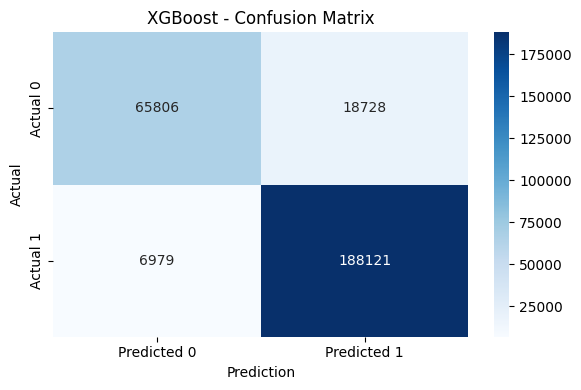

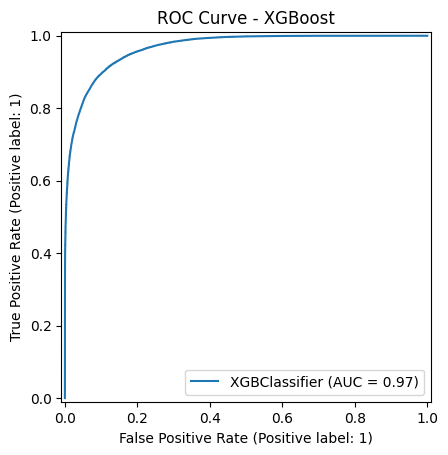


========== Decision Tree ==========
Cross-Validation AUC-ROC Scores: [0.98576015 0.9864455  0.98580867 0.98577708 0.98528421]
Mean CV AUC-ROC Score: 0.9858
Train Accuracy: 1.0000
Validation Accuracy: 0.9907
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     84534
           1       0.99      0.99      0.99    195100

    accuracy                           0.99    279634
   macro avg       0.99      0.99      0.99    279634
weighted avg       0.99      0.99      0.99    279634

Confusion Matrix:
 [[ 83266   1268]
 [  1327 193773]]
AUC-ROC Score: 0.9890992390555382


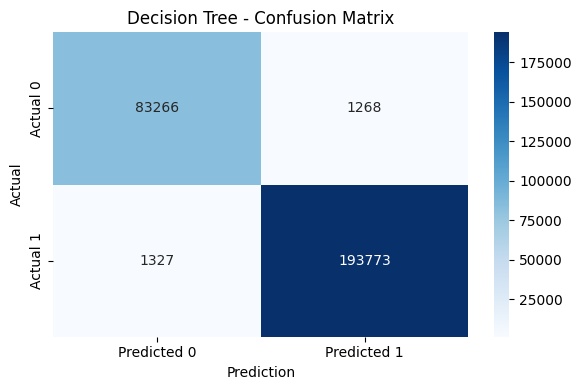

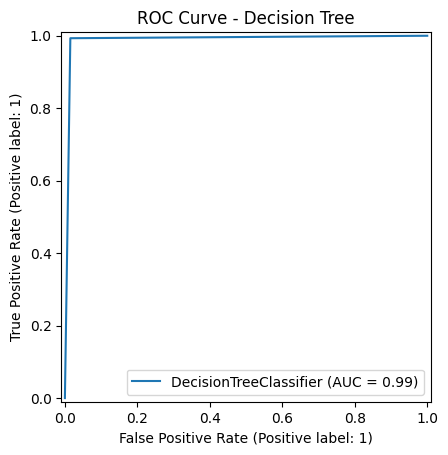


========== Random Forest ==========
Cross-Validation AUC-ROC Scores: [0.99943173 0.99943772 0.99937267 0.99942543 0.99934474]
Mean CV AUC-ROC Score: 0.9994
Train Accuracy: 1.0000
Validation Accuracy: 0.9934
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     84534
           1       0.99      1.00      1.00    195100

    accuracy                           0.99    279634
   macro avg       0.99      0.99      0.99    279634
weighted avg       0.99      0.99      0.99    279634

Confusion Matrix:
 [[ 83302   1232]
 [   609 194491]]
AUC-ROC Score: 0.9996471554601931


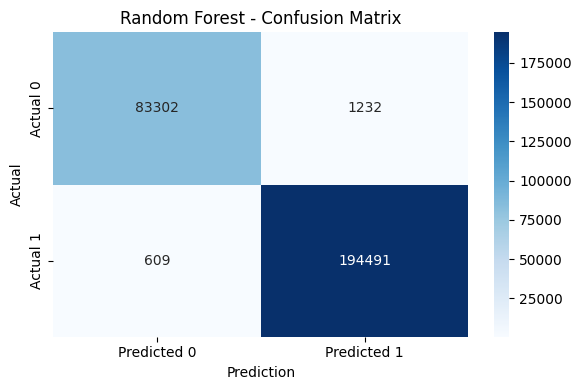

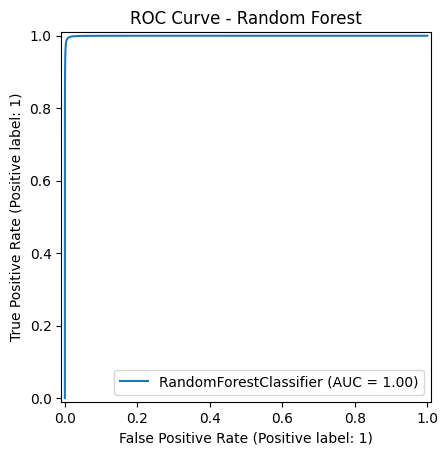


========== AdaBoost ==========
Cross-Validation AUC-ROC Scores: [0.82242456 0.81829953 0.81682732 0.81970924 0.81831683]
Mean CV AUC-ROC Score: 0.8191
Train Accuracy: 0.7776
Validation Accuracy: 0.7781
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.57      0.61     84534
           1       0.82      0.87      0.85    195100

    accuracy                           0.78    279634
   macro avg       0.74      0.72      0.73    279634
weighted avg       0.77      0.78      0.77    279634

Confusion Matrix:
 [[ 47900  36634]
 [ 25405 169695]]
AUC-ROC Score: 0.8182048498235881


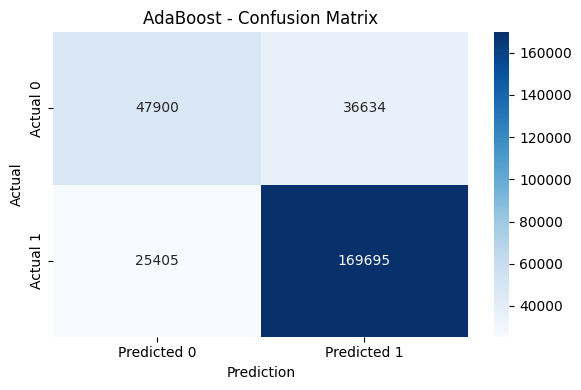

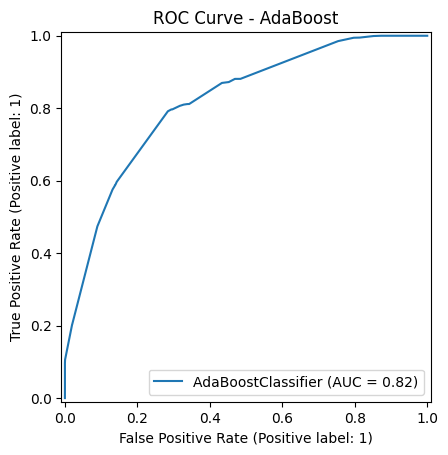


========== LightGBM ==========
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 624317, number of negative: 270508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3907
[LightGBM] [Info] Number of data points in the train set: 894825, number of used features: 168
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697697 -> initscore=0.836357
[LightGBM] [Info] Start training from score 0.836357
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 624317, number of negative: 270508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

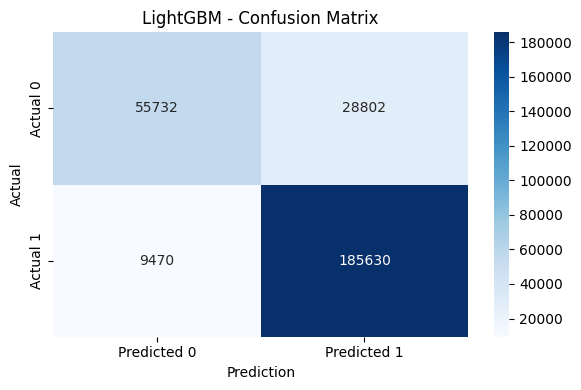

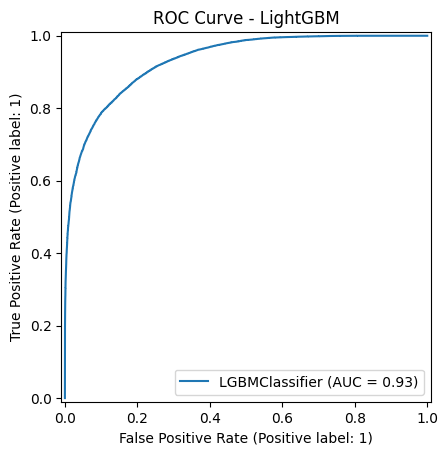

In [63]:
# Initialize models
xgb_model = XGBClassifier(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
ab_model = AdaBoostClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

# Evaluate
evaluate_model(xgb_model, "XGBoost", X_tr, X_val, y_tr, y_val)
evaluate_model(dt_model, "Decision Tree", X_tr, X_val, y_tr, y_val)
evaluate_model(rf_model, "Random Forest", X_tr, X_val, y_tr, y_val)
evaluate_model(ab_model, "AdaBoost", X_tr, X_val, y_tr, y_val)
evaluate_model(lgbm_model, "LightGBM", X_tr, X_val, y_tr, y_val)

In [70]:
models = [
    (xgb_model, "XGBoost"),
    (dt_model, "DecisionTree"),
    (rf_model, "RandomForest"),
    (ab_model, "AdaBoost"),
    (lgbm_model, "LightGBM")
]

for model, name in models:
    
    X_test = testing_data.drop(columns=['outcome'])

    y_test_probs = model.predict_proba(X_test)[:, 1]  # probability of class 1
    submission = pd.DataFrame({
        'activity_id': activity_ids,  # must match test file
        'outcome': y_test_probs                        # float values between 0 and 1
    })
    
    # Combine the model predictions with the excluded test entries
    submission = pd.concat([submission, excluded_test_rows[['activity_id', 'outcome']]], ignore_index=True)

    # Optional: Sort by 'activity_id' if required
    submission = submission.sort_values('activity_id').reset_index(drop=True)

    # Save to CSV
    submission_filename = f'submission_{name}.csv'
    submission.to_csv(submission_filename, index=False)
    print(f"Saved: {submission_filename}\n")


Saved: submission_XGBoost.csv

Saved: submission_DecisionTree.csv

Saved: submission_RandomForest.csv

Saved: submission_AdaBoost.csv

Saved: submission_LightGBM.csv



In [72]:
import os
import joblib


In [74]:
# Ensure the directory for saved models exists
os.makedirs('saved_models', exist_ok=True)

# List of trained models and their corresponding names
models = [
    (xgb_model, "XGBoost"),
    (dt_model, "DecisionTree"),
    (rf_model, "RandomForest"),
    (ab_model, "AdaBoost"),
    (lgbm_model, "LightGBM")
]

# Save each model individually
for model, name in models:
    filename = f'saved_models/{name}.joblib'
    joblib.dump(model, filename)
    print(f"Model saved: {filename}")


Model saved: saved_models/XGBoost.joblib
Model saved: saved_models/DecisionTree.joblib
Model saved: saved_models/RandomForest.joblib
Model saved: saved_models/AdaBoost.joblib
Model saved: saved_models/LightGBM.joblib


In [75]:
filename = f'saved_models/log_reg.joblib'
joblib.dump(log_reg, filename)
print(f"Model saved: {filename}")


Model saved: saved_models/log_reg.joblib
